In [113]:

#import packages
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

import random

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [114]:
#import loan data
loan200 = pd.read_csv('loan200.csv')
loan200.head()

,outcome,payment_inc_ratio,dti
0,target,9.00000,22.50
1,default,5.46933,21.33
2,paid off,6.90294,8.97
3,paid off,11.14800,1.83
4,default,3.72120,10.81


In [115]:
#KNN uses two inputs columns to predict the output (or outcome)
#Predictors are the features used for comparison; essentially feature selection
predictors = ['payment_inc_ratio', 'dti']
#Outcome is the outcome we measuring and attempting to predict
outcome = 'outcome'

In [116]:
#TARGET: This loan is to test the model and see the ouputs
newloan = loan200.loc[0:0, predictors]
newloan

,payment_inc_ratio,dti
0,9.0,22.5


In [117]:
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

In [118]:
#Run the KNN classifier - K should be between 1 and 20
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))
#45% defaulted, 55% paid off

[[0.45 0.55]]


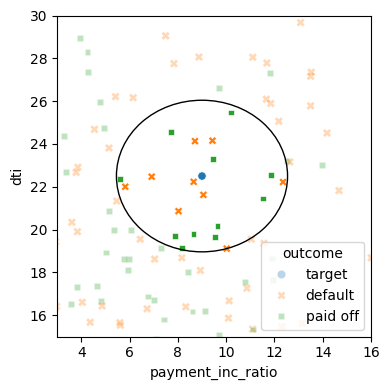

[ 9.  22.5]


In [119]:
#Plot model
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()
print(newloan.values[0])

In [120]:
#larger loan data sample that can utilize more features
loan_data = pd.read_csv('loan_data.csv')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

In [121]:
#In this case, KNN will use 4 feature columns to determine a set of
#similar members

predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

#In this scenario - revol_bal appears to be a indicator of closer neighbors?
#But it doesn't appear to be a good predictor of neighbors
#We should try to scale it using sklearn preprocessing

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4
       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [122]:
#Same methodology - the features are scaled.
# The reason the features are scaled is due to the various features
# are at different inherent scales; i.e. Peyment_inc_ratio and dti are similar
# scales between 0 and 5 or so. Where is a revol_util is a larger scale and revol_bal
# is in dollars, so a totally different value. The preprocessing will
# scale all the values to the same dimensions, and then run the calissfication
# process. 

newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(newloan)
print(X.iloc[nbrs[1][0], :])

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4
       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


count    45342.000000
mean         0.501091
std          0.128728
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


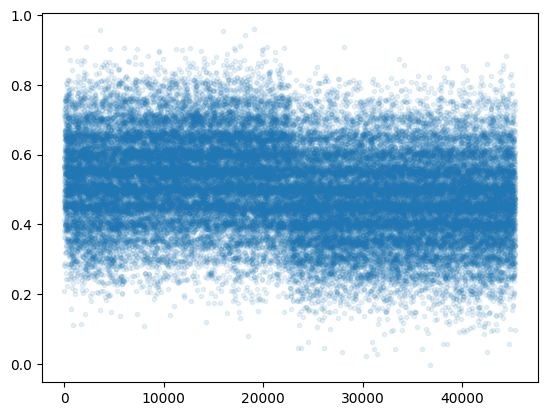

In [123]:
#knn can be run as an initial analysis and tacked on as feature to a broader
#regression analysis

##KNN as a feature engine


predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
            alpha=0.1, marker='.')
knn.predict_proba(X)[:, 0]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
print(loan_data['borrower_score'].describe())


In [124]:
loan_data[loan_data['borrower_score'] >= .80]

,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
208,10000,36 months,30000,16.56,14.37720,9781,88.1,credit_card,RENT,1,1,11,3.8,default,11,credit_card,RENT,> 1 Year,0.80
232,5000,36 months,42000,19.54,4.90143,8644,91.0,debt_consolidation,MORTGAGE,1,1,5,4.4,default,3,debt_consolidation,MORTGAGE,> 1 Year,0.80
284,4500,36 months,55000,18.92,3.36873,10637,66.8,debt_consolidation,RENT,0,1,16,4.4,default,11,debt_consolidation,RENT,> 1 Year,0.80
293,24000,60 months,85000,25.54,7.65572,29750,96.0,credit_card,MORTGAGE,1,1,10,6.0,default,4,credit_card,MORTGAGE,> 1 Year,0.80
301,1000,36 months,14400,15.00,2.94250,729,72.9,debt_consolidation,RENT,1,1,7,3.2,default,2,debt_consolidation,RENT,> 1 Year,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44377,3975,36 months,35000,5.73,5.41817,3318,94.8,home_improvement,OWN,0,1,4,1.8,paid off,11,home_improvement,OWN,> 1 Year,0.85
44791,12000,36 months,47000,18.77,11.04130,13888,81.7,debt_consolidation,MORTGAGE,1,1,7,3.2,paid off,2,debt_consolidation,MORTGAGE,> 1 Year,0.80
44822,10575,36 months,60000,24.20,7.34220,12087,84.5,debt_consolidation,MORTGAGE,0,1,11,4.4,paid off,5,debt_consolidation,MORTGAGE,> 1 Year,0.80
44962,8500,36 months,30000,9.72,11.61720,8240,71.7,debt_consolidation,RENT,1,1,3,4.6,paid off,4,debt_consolidation,RENT,> 1 Year,0.85
